# Introduction

In our first team meeting with our AD, we learned we've learned that our client **PowerCo** supplies electricity and gas to small and medium sized enterprises(SMEs). Due to an increased number of options(other service providers) in the market, our client is concerned of customers leaving for better offers from other energy providers and our overaching goal is to identify the drivers of this behaviour i.e. the leaving of customers.

Now, Estelle and I have been provided with two datasets - price data and customer data to:
1. Have a deeper understanding of this problem
2. Test our AD's hypothesis that price sensitivity influences churn. If so, by how much.

In [103]:
# DATA MANIPULATION
import os
import copy
import pandas as pd
import numpy as np

# DATA VIZ
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# STATISTICAL MODELLING
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
sns.set(color_codes=True)

# Loading data and other fluff

We need to load `client_data.csv` and `price_data.csv` into individual dataframes so that we can work with them in Python. For this notebook and all further notebooks, it will be assumed that the CSV files will the placed in the same file location as the notebook. If they are not, please adjust the directory within the `read_csv` method accordingly.

In [104]:
POWERCO_COLOURS = ["#0072CE", "#B4B4B3", "#79B8F3", "#FDB927", "#F7941D", "#4CB748", "#2E3192"]
DIVERGENT_COLOUR_GRADIENT = ["#e2f1fc", "#b9dcfa", "#8cc7f7", "#5eb1f3", "#39a0f1", "#0691ef"]
sns.set_palette(POWERCO_COLOURS)

In [105]:
client_df = pd.read_csv('./client_data.csv')
price_df = pd.read_csv('./price_data.csv')

You can view the first 3 rows of a dataframe using the `head` method. Similarly, if you wanted to see the last 3, you can use `tail(3)`

In [106]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [107]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


## Descriptive statistics of data

### Data types

It is useful to first understand the data that you're dealing with along with the data types of each column. The data types may dictate how you transform and engineer features.

To get an overview of the data types within a data frame, use the `info()` method.

In [108]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [109]:
client_date_cols = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]
object_cols = client_df.select_dtypes(include='object').columns.difference(['id'] + client_date_cols)

for col in object_cols:
  print(f"{col}: {client_df[col].unique()}\n")

channel_sales: ['foosdfpfkusacimwkcsosbicdxkicaua' 'MISSING'
 'lmkebamcaaclubfxadlmueccxoimlema' 'usilxuppasemubllopkaafesmlibmsdf'
 'ewpakwlliwisiwduibdlfmalxowmwpci' 'epumfxlbckeskwekxbiuasklxalciiuu'
 'sddiedcslfslkckwlfkdpoeeailfpeds' 'fixdbufsefwooaasfcxdxadsiekoceaa']

has_gas: ['t' 'f']

origin_up: ['lxidpiddsbxsbosboudacockeimpuepw' 'kamkkxfxxuwbdslkwifmmcsiusiuosws'
 'ldkssxwpmemidmecebumciepifcamkci' 'MISSING'
 'usapbepcfoloekilkwsdiboslwaxobdp' 'ewxeelcelemmiwuafmddpobolfuxioce']



In [110]:
def map_column_to_integers(df, column_names):
    for column_name in column_names:
      factorized_values, unique_values = pd.factorize(df[column_name][df[column_name] != 'MISSING'])

      mapping = dict(zip(unique_values, range(len(unique_values))))
      mapping['MISSING'] = -1

      df[column_name] = df[column_name].map(mapping)
    return df

In [111]:
client_df = map_column_to_integers(client_df, object_cols)

In [112]:
for col in object_cols:
  print(f"{col}: {client_df[col].unique()}\n")

channel_sales: [ 0 -1  1  2  3  4  5  6]

has_gas: [0 1]

origin_up: [ 0  1  2 -1  3  4]



In [113]:
# Lemme fix this grave mistake that I've done
client_df.rename(columns={'has_gas': 'no_gas'}, inplace=True)
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  int64  
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

As they said, the date has already been cleaned so there's not much of cleaning work for us. The only issue I'm noticing is that the dates are saved as string values so we're going to change that. Otherwise things like missing data have already been taken care of. I did notice that ***channel_sales*** have a value labelled *MISSING* so I guess that's a way to signify missingness.

Let's change the datetypes of date columns and move on to the other dataset

In [114]:
for col in client_date_cols:
  client_df[col] = pd.to_datetime(client_df[col])

client_df[client_date_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_activ       14606 non-null  datetime64[ns]
 1   date_end         14606 non-null  datetime64[ns]
 2   date_modif_prod  14606 non-null  datetime64[ns]
 3   date_renewal     14606 non-null  datetime64[ns]
dtypes: datetime64[ns](4)
memory usage: 456.6 KB


In [115]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


In [116]:
price_df['price_date'] = pd.to_datetime(price_df['price_date'])

### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

In [117]:
client_df.describe().T

,count,mean,std,min,25%,50%,75%,max
channel_sales,14606.0,0.248254,1.128506,-1.0,-1.000000,0.000000,1.000000,6.000000e+00
cons_12m,14606.0,159220.286252,573465.264198,0.0,5674.750000,14115.500000,40763.750000,6.207104e+06
cons_gas_12m,14606.0,28092.375325,162973.059057,0.0,0.000000,0.000000,0.000000,4.154590e+06
cons_last_month,14606.0,16090.269752,64364.196422,0.0,0.000000,792.500000,3383.000000,7.712030e+05
forecast_cons_12m,14606.0,1868.614880,2387.571531,0.0,494.995000,1112.875000,2401.790000,8.290283e+04
forecast_cons_year,14606.0,1399.762906,3247.786255,0.0,0.000000,314.000000,1745.750000,1.753750e+05
forecast_discount_energy,14606.0,0.966726,5.108289,0.0,0.000000,0.000000,0.000000,3.000000e+01
forecast_meter_rent_12m,14606.0,63.086871,66.165783,0.0,16.180000,18.795000,131.030000,5.993100e+02
forecast_price_energy_off_peak,14606.0,0.137283,0.024623,0.0,0.116340,0.143166,0.146348,2.739630e-01
forecast_price_energy_peak,14606.0,0.050491,0.049037,0.0,0.000000,0.084138,0.098837,1.959750e-01


In [118]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


---

## Data visualization

If you're working in Python, two of the most popular packages for visualization are `matplotlib` and `seaborn`. We highly recommend you use these, or at least be familiar with them because they are ubiquitous!

Below are some functions that you can use to get started with visualizations.

In [119]:
def plot_stacked_bars(dataframe, title_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=14)
    # Rename legend
    plt.legend(["Retention", "Churn"], loc=legend_)
    # Labels
    plt.ylabel("Company base (%)")
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="white", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:

        # Calculate annotation
        value = str(round(p.get_height(),1))
        # If value is 0 do not annotate
        if value == '0.0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.05, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

def plot_distribution(dataframe, column, ax, bins_=50):
    """
    Plot variable distirbution in a stacked histogram of churned or retained company
    """
    # Create a temporal dataframe with the data to be plot
    temp = pd.DataFrame({"Retention": dataframe[dataframe["churn"]==0][column],
    "Churn":dataframe[dataframe["churn"]==1][column]})
    # Plot the histogram
    temp[["Retention","Churn"]].plot(kind='hist', bins=bins_, ax=ax, stacked=True)
    # X-axis label
    ax.set_xlabel(column)
    # Change the x-axis to plain style
    ax.ticklabel_format(style='plain', axis='x')

Thhe first function `plot_stacked_bars` is used to plot a stacked bar chart. An example of how you could use this is shown below:

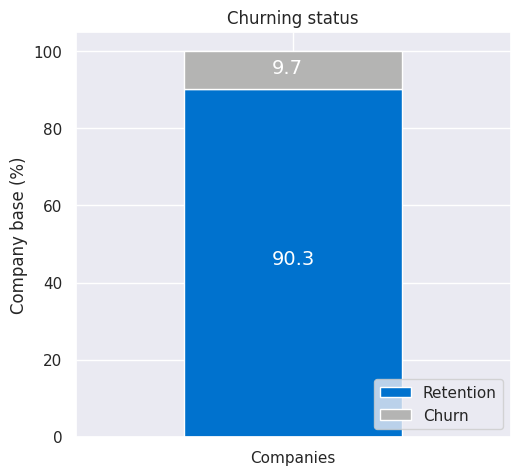

In [120]:
churn = client_df[['id', 'churn']]
churn.columns = ['Companies', 'churn']
churn_total = churn.groupby(churn['churn']).count()
churn_percentage = churn_total / churn_total.sum() * 100
plot_stacked_bars(churn_percentage.transpose(), "Churning status", (5, 5), legend_="lower right")

The second function `annotate_bars` is used by the first function, but the third function `plot_distribution` helps you to plot the distribution of a numeric column. An example of how it can be used is given below:

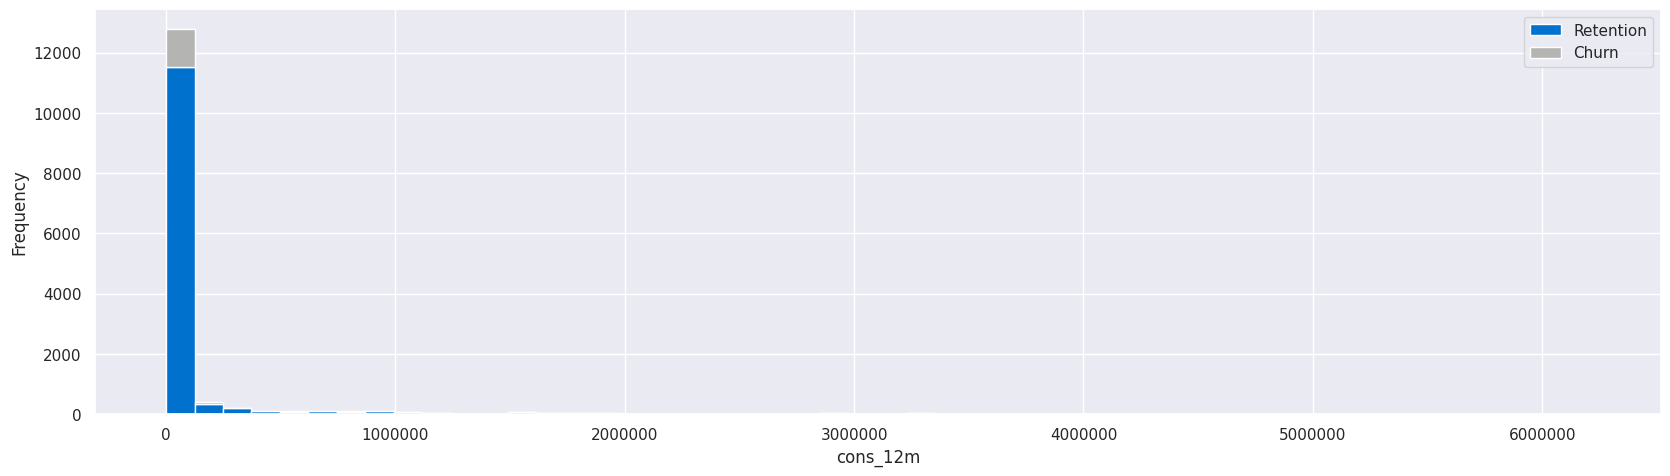

In [121]:
consumption = client_df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'imp_cons', 'no_gas', 'churn']]

fig, axs = plt.subplots(nrows=1, figsize=(18, 5))

plot_distribution(consumption, 'cons_12m', axs)

# Understand Our Client's Clientele & Price Dynamics

The goal of this section is to have a high-level understanding of our client's customers. We'll also get a sense of how the client has been working with their products' prices before we actually explore whether or not these prices were part of their customers' decision-making as they decided to stay or leave.

Understanding the customers
- [x] How many customers do we have and how did we get them(origin_up)?
- [x] When did we have these customers(contract activation) and how long have we had them(antiquity)?
- [x] How much time is remaining until their contracts expire?
- [x] How much electricity and gas have they consumed?

## Customer Exploratory Analysis

In [122]:
customer_num = len(client_df.id.unique())

print(f"The client has {customer_num} customers")

The client has 14606 customers


In [123]:
daily_activations_num = (
    client_df
    .groupby(pd.Grouper(key='date_activ', freq='D'))['id']
    .count()
    .reset_index(name='activations_num')
    .set_index('date_activ')
)

daily_activations_num.head()

,activations_num
date_activ,
2003-05-09,1
2003-05-10,0
2003-05-11,0
2003-05-12,0
2003-05-13,0


In [124]:
daily_activations_num['activations_num'].sum()

14606

In [125]:
fig = px.line(
      daily_activations_num,
      x=daily_activations_num.index,
      y='activations_num',
      labels={'activations_num': 'Number of Activations'},
      title='Number of Daily Contract Activations'
    )

fig.update_layout(xaxis_title='Date', yaxis_title='Number of Activations')

fig.show()

I didn't expect 14k data points distributed over 15 years to create such a noisy data. Let's downsample to monthly data instead.

In [126]:
monthly_activations_num = daily_activations_num.resample('M').sum()

fig = px.line(
    monthly_activations_num,
    x=monthly_activations_num.index,
    y='activations_num',
    labels={'activations_num': 'Number of Activations'},
)

fig.add_trace(
    go.Scatter(
        x=['2009-07-01', '2009-07-01', '2009-07-01'],
        y=[0, 600, None],
        mode='lines',
        line=dict(color=POWERCO_COLOURS[1], dash='dash'),
        name='June 2009'
    )
)

fig.add_trace(
    go.Scatter(
        x=['2011-05-01', '2011-05-01', '2011-05-01'],
        y=[0, 600, None],
        mode='lines',
        line=dict(color=POWERCO_COLOURS[1], dash='dash'),
        name='April 2011'
    )
)

fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=1.06,
        text='All customers acquired in the last 4 years',
        showarrow=False,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="top",
        font=dict(size=16),
        align='left'
    )
)

fig.update_layout(
    title='<b>Monthly Contract Activations since 2004</b>',
    xaxis_title='Monthly Dates',
    yaxis_title='Number of Activations',
    showlegend=False
)

fig.show()

So it seems even though the business started way back in 2004, the actual work with the customers started in the last 4 years, with the customers coming from 2 major spikes i.e. one starting in June of 2009 and the other in April of 2011. Perhaps these were the periods of some sort of campaigns.

When will these contracts end?

In [127]:
daily_deactivations_num = (
    client_df
    .groupby(pd.Grouper(key='date_end', freq='D'))['id']
    .count()
    .reset_index(name='deactivations_num')
    .set_index('date_end')
)

daily_deactivations_num.head()

,deactivations_num
date_end,
2016-01-28,28
2016-01-29,16
2016-01-30,28
2016-01-31,34
2016-02-01,145


In [128]:
fig = px.line(
    daily_deactivations_num,
    x=daily_deactivations_num.index,
    y='deactivations_num',
    labels={'deactivations_num': 'Number of Deactivations'},
)

fig.update_layout(
    title='<b>Expected Contract Deactivations</b>',
    xaxis_title='Monthly Dates',
    yaxis_title='Number of Deactivations',
    showlegend=False
)

fig.show()

In [129]:
client_df['contract_len(yrs)'] = ((client_df['date_end'] - client_df['date_activ']).dt.days / 365.25).astype(int)

In [130]:
client_df['remaining_contr_len'] = ((client_df['date_end'] - client_df['date_modif_prod']).dt.days / 365.25).astype(int)

In [131]:
contract_lens = (
      client_df[['id', 'contract_len(yrs)']]
      .groupby('contract_len(yrs)')['id']
      .count()
      .reset_index(name='customers')
      .set_index('contract_len(yrs)')
    )
contract_lens.head()

,customers
contract_len(yrs),
2,263
3,1169
4,3801
5,3067
6,3085


In [132]:
fig = px.bar(
      contract_lens,
      x=contract_lens.index,
      y='customers',
      labels={'contract_len(yrs)': 'Contract Lengths', 'customers': 'Number of Customers'},
      title="<b>Customers' Contract Lengths<b>",
    )

fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=1.1,
        text='Optimal Contract Lengths: Customers Favor 4 to 7 Years and Shy Away from the Extremes',
        showarrow=False,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="top",
        font=dict(size=16),
        align='left'
    )
)

fig.show()

In [133]:
fig = px.histogram(
      client_df,
      x='num_years_antig',
      nbins=50,
      labels={'num_years_antig': 'Years with the Company'},
      title='<b>Distribution of Customer Antiquity<b>',
    )

fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=1.1,
        text='The majority of customers have been with us between 3 and 6 years',
        showarrow=False,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="top",
        font=dict(size=16),
        align='left'
    )
)

fig.show()

At first I thought this was redundant as the majority of customers were supposed to have about 4 or 5 years with the company, but it turns out it's 6. I'm beginning to wonder whether my assumption that this is 2014 data is correct, because if it is, then we can't have the majority of customers having 6 longevity. Unless these customers were there before June 2009, just working without contracts i.e. the idea of contracts was largely rolled out in 2009.

In [134]:
id_counts = client_df.groupby('origin_up')['id'].count().reset_index(name='id_count')


In [135]:
fig = px.bar(
      id_counts,
      x='origin_up',
      y='id_count',
      labels={'origin_up': 'Electricity Campaign Codes', 'id_count': 'Number of Subscribers'},
      title='<b>Number of Subscribers per Electricity Campaign Code<b>',
    )

fig.add_annotation(
    go.layout.Annotation(
        x=0,
        y=1.1,
        text='Only 64 customers never subcribed via an electricty campaign',
        showarrow=False,
        xref="paper",
        yref="paper",
        xanchor="left",
        yanchor="top",
        font=dict(size=16),
        align='left'
    )
)

fig.show()

Looks like campaigns 3 and 4 were not successful at all, while campaigns 0, 1 and 2 were wildly successful. In that order.

**Consumption Distributions**

The distributions of both Electricity and Gas consumptions over the past 12 months exhibit a significant right skewness, rendering traditional visualization methods less informative. Notably, the majority of customers demonstrate minimal or no gas consumption. Among the minority of gas consumers, the usage spans a wide range, from a few thousand units to several million units, forming a sparsely distributed pattern.

In the case of electricity consumption, a similar right-skewed distribution is observed. However, there is a higher prevalence of customers using electricity, with consumption typically falling within the range of a few thousand to 30 thousand units—the standard usage range for most companies. Notably, there are outliers with consumption levels extending beyond the 30k units threshold, reaching up to around 6 million units.

**Remainings**

I needed to have checked number of products and services each customer has active and finally build a segmentation model to group our customers i.e. assuming there's a meaningful way to segment customers.

In [136]:
n_prods_cus_count = (
    client_df[['id', 'nb_prod_act']]
    .groupby(['nb_prod_act'])['id']
    .count()
    .reset_index(name='customers')
    .set_index('nb_prod_act')
)

In [137]:
fig = px.bar(
        n_prods_cus_count,
        x=n_prods_cus_count.index,
        y='customers',
        labels={'nb_prod_act': 'Number of Products & Services', 'customers': 'Number of Customers'},
        title='<b>Number of Products Used By Customers<b>',
    )

fig.show()

So most customers use only 1 product/service... Okay!

## Customer Segmentation

Our next goal is to summary the above analysis by grouping customers into segments; something we'll do using an unsupervised learning algorithm like K-Means clustering.

Segmentation Roadmap
- [x] Use PCA to identify variables that explain variability in the data
- [x] Use these variables to group customers into segments

In [138]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  int64         
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [139]:
customer_desc_cols = [
    'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
    'date_activ', 'date_end', 'date_modif_prod', 'date_renewal', 'no_gas',
    'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
    'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
    'contract_len(yrs)'
]

#### Scaling The Data

In [140]:
cp_client_df = copy.deepcopy(client_df)
cp_client_df[client_date_cols] = cp_client_df[client_date_cols].apply(lambda x: x.astype(int) / 10**9)
cp_client_df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'no_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'contract_len(yrs)', 'remaining_contr_len'],
      dtype='object')

In [141]:
client_df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'no_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'contract_len(yrs)', 'remaining_contr_len'],
      dtype='object')

In [142]:
scalar = StandardScaler()
scaled_array = scalar.fit_transform(cp_client_df[customer_desc_cols])

#### Principal Component Analysis

In [143]:
pca = PCA()
pca.fit(scaled_array)
pca_data = pca.transform(scaled_array)

In [144]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
scree_data = pd.DataFrame({'Principal Component': labels, 'Percentage of Explained Variance': per_var})

fig = px.bar(
      scree_data,
      x='Principal Component',
      y='Percentage of Explained Variance',
      labels={'Percentage of Explained Variance': 'Percentage of Explained Variance'},
      title='Scree Plot',
    )

fig.update_layout(
    xaxis_title='Principal Components',
    yaxis_title='Percentage of Explained Variance'
)

fig.show()

Great! We're going to use the first 2 PCs to visualize the data. However, I think it's worth our effort to check the number of PCs that may actually be useful in describing the majority of variation by checking the cumulative explained variance in the data

In [145]:
scree_data.head()

,Principal Component,Percentage of Explained Variance
0,PC1,19.2
1,PC2,14.9
2,PC3,13.2
3,PC4,8.9
4,PC5,8.0


In [146]:
scree_data['Cumulative Explained Variance'] = np.cumsum(per_var)

fig = px.bar(
    scree_data,
    x='Principal Component',
    y='Percentage of Explained Variance',
    labels={'Percentage of Explained Variance': 'Percentage of Explained Variance'},
    title='Scree Plot with Cumulative Explained Variance'
)

fig.add_trace(
    go.Scatter(
          x=scree_data['Principal Component'],
          y=scree_data['Cumulative Explained Variance'],
          mode='lines+markers',
          name='Cumulative Explained Variance'
        )
    )

fig.update_layout(
    xaxis_title='Principal Components',
    yaxis_title='Percentage of Explained Variance',
)

fig.show()

In [147]:
pca_data_df = pd.DataFrame(pca_data, columns=labels)
pca_data_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-2.792273,1.122261,-0.169868,1.493368,-1.292329,2.014884,2.451963,1.143836,-0.196399,0.705650,-1.311625,-1.327913,0.296729,-0.755418,-0.119891,0.083284,0.076888,0.152240,-0.000125
1,2.182113,-0.805230,0.122830,-0.392221,0.083353,-0.532183,0.207201,-0.511401,0.385899,0.818647,0.193163,0.095560,0.013934,0.056602,0.091365,0.095656,-0.159223,-0.103363,0.000117
2,0.895251,-0.292529,1.339168,-1.394698,0.075293,-0.385549,-0.132375,-0.132428,0.342070,0.331629,-0.001659,0.139394,-0.047890,0.035746,-0.039934,0.055075,-0.044328,0.074947,-0.000145
3,0.633747,-0.220432,1.454645,-1.572269,0.131314,-0.388138,-0.506479,0.350871,0.689142,-0.111015,-0.182702,0.202697,-0.024980,0.049107,-0.050778,0.074403,-0.072348,0.045069,-0.000224
4,0.862596,0.269698,2.548508,-1.082130,-0.091531,-0.459780,0.131516,-0.644137,-0.023613,0.716434,0.244511,0.163166,-0.008453,0.013224,-0.053713,0.079494,-0.101880,-0.032515,-0.000059


In [148]:
fig = px.scatter(
        pca_data_df,
        x='PC1',
        y='PC2',
        title='The PCA Graph',
        labels={'PC1': f'PC1 - {per_var[0]}%', 'PC2': f'PC2 - {per_var[1]}%'}
    )

fig.show()

Looks like we have 2 or 3 groups... Interesting! Let's take this further with K-Means Clustering. But we'll first have to see the variables that make up most of the variability

In [149]:
loading_scores = (
      pd.DataFrame(
          pca.components_.T,
          columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)]
    )
)

loading_scores.index = customer_desc_cols

sorted_loading_scores = (
    loading_scores
    .abs()
    .sort_values(
        by='PC1',
        axis=0,
        ascending=False
    )
)

In [150]:
fig = px.bar(
      sorted_loading_scores,
      x=sorted_loading_scores.index,
      y='PC1',
      labels={'PC1': 'Absolute Loading Scores'},
      title='Variable Impact on Variability'
    )

fig.update_layout(
    xaxis_title='Variables',
    yaxis_title='Absolute Loading Scores'
)

fig.show()

Now I have to decide on which variables to pick to train my K-Means model on. According to ChatGPT, the K-Means clustering algorithm is also one of those algorithms affected by multicollinearity. Just intuition can tell that some of these "important" variables are linearly correlated, but let's check the correlation matrix anyways.

In [151]:
scaled_df = pd.DataFrame(scaled_array, columns=customer_desc_cols)

In [152]:
clustering_cols = [
    'contract_len(yrs)',
    'date_activ',
    'num_years_antig',
    'date_modif_prod',
    'channel_sales',
    'origin_up',
    'margin_net_pow_ele',
    'margin_gross_pow_ele',
    'date_renewal',
    'date_end'
]

scaled_corr = scaled_df[clustering_cols].corr()

In [153]:
fig = px.imshow(
    scaled_corr,
    labels=dict(x='Features', y='Features', color='Correlation'),
    x=scaled_corr.columns,
    y=scaled_corr.columns,
    color_continuous_scale=DIVERGENT_COLOUR_GRADIENT,
    title='Correlation Matrix'
  )

fig.update_layout(
    width=800,
    height=800,
    xaxis=dict(
          tickmode='array',
          tickvals=list(range(len(scaled_corr.columns))),
          ticktext=scaled_corr.columns,
          tickangle=-90
        ),
)

fig.show()

In [154]:
def calculate_and_view_vif(data, columns):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = columns
    vif_data["VIF"] = [variance_inflation_factor(data[columns].values, i) for i in range(len(columns))]

    fig = px.bar(
      vif_data.sort_values(by='VIF', ascending=False),
      x='Variable',
      y='VIF',
      title="Variables' Variance Inflation Factor"
    )

    fig.update_layout(
        xaxis_title='Variables',
        yaxis_title='Variance Inflation Factor'
    )

    fig.show()


In [155]:
customer_desc_cols = [
    'contract_len(yrs)',
    # 'date_activ',
    'date_modif_prod',
    'channel_sales',
    'origin_up',
    'margin_net_pow_ele',
    'date_renewal'
]

In [156]:
calculate_and_view_vif(scaled_df, customer_desc_cols)

After multiple iterations of computing the VIF, I think I should be working with the following explanatory variables:
- contract_len(yrs)
- date_modif_prod
- channel_sales
- date_renewal
- origin_up
- margin_net_pow_ele

### K-Means Clustering

In [157]:
scaled_df.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,no_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn,contract_len(yrs)
0,-0.219992,-0.277655,0.164779,-0.249996,1.474078,-0.400888,1.119290,-0.238930,-2.123586,-0.447586,0.043246,0.043376,0.997048,1.570703,-1.239571,-0.899951,1.885055,3.048469,-1.366871
1,-1.106150,-0.269529,-0.172380,-0.249996,-0.891450,0.309857,-1.333982,0.343806,0.470901,-0.447586,-0.404594,-0.404483,-0.411900,-0.546444,0.621825,0.347646,-0.320308,-0.328033,0.991886
2,-0.219992,-0.276707,-0.172380,-0.249996,-0.487579,-0.962003,-1.075971,-0.804775,0.470901,-0.447586,0.199446,0.199583,-0.411900,-0.585862,0.621825,0.347646,-0.316170,-0.328033,0.402197
3,0.666166,-0.274893,-0.172380,-0.249996,-0.516427,-1.120986,-1.094400,-0.948348,0.470901,-0.447586,0.279523,0.279664,-0.411900,-0.525372,0.621825,0.347646,-0.364640,-0.328033,0.402197
4,-1.106150,-0.269939,-0.172380,-0.241824,-0.645394,-1.336080,-1.176791,-1.134148,0.470901,-0.294316,1.005655,1.005828,-0.411900,-0.453144,0.621825,0.347646,0.123011,-0.328033,0.402197


In [158]:
inertia = []
range_val = range(1, 20)

for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pd.DataFrame(scaled_df[customer_desc_cols]))
    inertia.append(kmean.inertia_)

fig = px.line(
    x=range_val,
    y=inertia,
    markers=True,
    labels={'x': 'Values of K', 'y': 'Inertia'},
    title='The Elbow Method using Inertia',
)

fig.update_layout(xaxis_title='Values of K', yaxis_title='Inertia')
fig.show()

Looking at the PCA results, I think we actually have 3. For the sake of curiosity, how about I check the number of clusters based on the PCs?

In [159]:
inertia = []
range_val = range(1, 20)

for i in range_val:
    kmean = KMeans(n_clusters=i)
    kmean.fit_predict(pca_data_df)
    inertia.append(kmean.inertia_)

fig = px.line(
    x=range_val,
    y=inertia,
    markers=True,
    labels={'x': 'Values of K', 'y': 'Inertia'},
    title='The Elbow Method using Inertia on the PCs',
)

fig.update_layout(xaxis_title='Values of K', yaxis_title='Inertia')
fig.show()

See? In line with my intuition. However, this is difficult to work with as our main interest is the explainability. Since we aren't using the variables directly, then the PCs won't be as interpretable as we'd like. Let's experiment nontheless

In [160]:
clustering_cols = [
    'contract_len(yrs)',
    'date_modif_prod',
    'channel_sales',
    'date_renewal',
    'origin_up',
    'margin_net_pow_ele']

In [161]:
def get_k_means_results(df, k):
  kmeans_model=KMeans(k)
  kmeans_model.fit_predict(df)

  k_means_data = pd.DataFrame({'cluster': kmeans_model.labels_})
  return k_means_data

In [162]:
vars_groups_data = pd.DataFrame(scaled_df[customer_desc_cols])
vars_groups = get_k_means_results(vars_groups_data, 2)

In [163]:
vars_groups.head()

,cluster
0,0
1,1
2,1
3,1
4,1


In [164]:
pcs_groups_data = pca_data_df
pcs_groups = get_k_means_results(pcs_groups_data, 3)

In [165]:
vars_groups.rename(columns={'cluster': 'vars_clusters'}, inplace=True)
pcs_groups.rename(columns={'cluster': 'pcs_clusters'}, inplace=True)
scaled_df = pd.concat([scaled_df, vars_groups, pcs_groups, pca_data_df[['PC1', 'PC2']]], axis=1)
client_df = pd.concat([client_df, vars_groups, pcs_groups, pca_data_df[['PC1', 'PC2']]], axis=1)
scaled_df.head()

,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,no_gas,imp_cons,...,net_margin,num_years_antig,origin_up,pow_max,churn,contract_len(yrs),vars_clusters,pcs_clusters,PC1,PC2
0,-0.219992,-0.277655,0.164779,-0.249996,1.474078,-0.400888,1.119290,-0.238930,-2.123586,-0.447586,...,1.570703,-1.239571,-0.899951,1.885055,3.048469,-1.366871,0,1,-2.792273,1.122261
1,-1.106150,-0.269529,-0.172380,-0.249996,-0.891450,0.309857,-1.333982,0.343806,0.470901,-0.447586,...,-0.546444,0.621825,0.347646,-0.320308,-0.328033,0.991886,1,0,2.182113,-0.805230
2,-0.219992,-0.276707,-0.172380,-0.249996,-0.487579,-0.962003,-1.075971,-0.804775,0.470901,-0.447586,...,-0.585862,0.621825,0.347646,-0.316170,-0.328033,0.402197,1,0,0.895251,-0.292529
3,0.666166,-0.274893,-0.172380,-0.249996,-0.516427,-1.120986,-1.094400,-0.948348,0.470901,-0.447586,...,-0.525372,0.621825,0.347646,-0.364640,-0.328033,0.402197,1,0,0.633747,-0.220432
4,-1.106150,-0.269939,-0.172380,-0.241824,-0.645394,-1.336080,-1.176791,-1.134148,0.470901,-0.294316,...,-0.453144,0.621825,0.347646,0.123011,-0.328033,0.402197,1,0,0.862596,0.269698


In [166]:
def view_k_means_groups(df, cluster_name):
    fig = px.scatter(
      df,
      x='PC1',
      y='PC2',
      color=cluster_name,
      color_continuous_scale=POWERCO_COLOURS,
      title='Customer Clusters'
    )

    fig.show()

In [167]:
view_k_means_groups(scaled_df, 'vars_clusters')

In [168]:
view_k_means_groups(scaled_df, 'pcs_clusters')

**NOW THIS... THIS IS WHAT I'VE BEEN TALKING ABOUT LADIES AND GENTLEMEN**

In trying to make the 2 results work together, let's visualize the PCs clusters by 2 variables and see what scatter plot they bring.
- We use 2 variables because we want to view these on a scatter plot.
- We'll use variables ***contract_len_(yrs)*** and ***margin_net_pow_ele***. This is because they're part of vars that explain most variation and will probably also make business sense if they'll provide clear patterns

In [169]:
def create_histogram_figure(df, x, color, title):
    fig = px.histogram(
        df,
        x=x,
        color=color,
        labels={color: f'{title}'},
    )
    return fig

def view_dist_by_clusters(input_x, clusters_info, by=None):
    num_clusters = len(clusters_info)

    fig = make_subplots(rows=1, cols=num_clusters, subplot_titles=[info['title'] for info in clusters_info])

    for i, cluster_info in enumerate(clusters_info, start=1):
        cluster_fig = create_histogram_figure(client_df, input_x, cluster_info['cluster'], cluster_info['title'])
        for trace in cluster_fig.data:
            fig.add_trace(trace, row=1, col=i)

    fig.update_layout(
        title=f'<b>Customer Clusters by {by}<b>',
        title_x=0.5,
        height=400,
        width=1000,
        showlegend=True
    )

    fig.show()

In [170]:
input_x = "contract_len(yrs)"
clusters_info = [
    {"cluster": "vars_clusters", "title": "Variables Clusters"},
    {"cluster": "pcs_clusters", "title": "PCs Clusters"}
]

view_dist_by_clusters(input_x, clusters_info, by="Contract Lengths")

If I were to be asked which clustering model to put into production, I'd be a little puzzled reasoning for or against either. But I personally prefer the 3 clusters as I think they capture a little more of the nuances in the differences. For example, if we look at contract lengths above, we see that, yes there are 2 major clusters, 0 - 5 years and 5 years and above. However, the third cluster seem to represent a nuanced group that's somewhere in-between which I think will quite improve customer satisfaction as their nuanced needs will be considered. We can say more about this if we do analyse what describes each cluster.

In [171]:
input_x = "margin_net_pow_ele"
clusters_info = [
    {"cluster": "vars_clusters", "title": "Variables Clusters"},
    {"cluster": "pcs_clusters", "title": "PCs Clusters"}
]

view_dist_by_clusters(input_x, clusters_info, by="Net Power Consumption")

## Conclusion

In conclusion, **PowerCo** has 14606 customers, the majority of which have been with the company between 3 and 6 years.

This level of loyalty is also supported by lengthy contracts, majority of which are between 4 and 7 years, which a few outliers going all the way to 12 years.

These contracts were largely activated in 2 periods; the first one starting in June 2009 to March 2011, this is the period where the most contracts were activated. The second period followed immediately after, which was in April 2011 and activated the rest of the currently available contracts between April 2011 to July 2013.

Along the way, five electricity campaigns labelled 0 to 4 were offered and only 64 customers did not subscribe to any of them. Customers subscribed to campaign 0, 1 and 2, in that order of majority, while campaigns 3 and 4 had practically no subscribers.

# Defining The Problem

We now have a general sense of our clients' customers, so we can now move on to getting into the details of having an in-depth understanding of our problem before we investigate its cause.

To get a quantitative description of churn, we'll explore the following:
- [x] What is the overall churn rate?
- [x] Is there a temporal pattern to churn? For example, months and years with increase churn rates.
- [x] How does churn rate vary across customer segments?
  - [x] Customer antiquity and contract duration
  - [X] Campaigns that customers first subscribed to
  - [ ] ~How does churn vary based on the subscribed power level (pow_max) or the number of active products and services?~

To quantify the impact of churn, we'll explore the following:
- [ ] How much demand have we lost?
- [ ] What about revenue?
  - [ ] What is the financial impact of churn on forecasted revenue?
  - [ ] How does the churn rate correlate with changes in net margin and gross margin on power subscriptions?

## Quantifying Churn

To quantify the problem of churn, let's check what impact this has had on the business so far. The most important aspect being **revenue** perhaps followed by **demand** or vice-versa.

On the other hand however, we don't know when a user had churned, we only know that they've churned so the interpretation of some of the values below may not be precise. In a real scenerio, we'd ask for this information.

Anyway, let's continue. I would like to compare imp_cons(currently paid consumption) with overall consumption of churned clients under the assumption that... Ayi, angyeke

## Correlation with Churn

In [172]:
churn = client_df[['id', 'churn']].groupby('churn')['id'].count().reset_index(name='counts').set_index('churn')

In [173]:
total_customers = churn['counts'].sum()
churn['percentages'] = ((churn['counts'] / total_customers) * 100).round(2)

In [174]:
churn

,counts,percentages
churn,,
0,13187,90.28
1,1419,9.72


Ideally, I would like to know when customers were considered to be churned, in order to under the time when clients leave. However, since we don't have such data recorded, we have to work with what we have. Initially, I though the time of activating the account could be useful in this regard, however, most contracts were activated at about the same time, so this won't be useful. I therefore think we should count number of churned accounts by the latest dates when contracts were modified.

In [175]:
churn_contract_last_mod = (
    client_df[['date_modif_prod', 'churn']]
    .groupby(['churn', pd.Grouper(key='date_modif_prod', freq='W')])['churn'] # trial an error on whether to use D, W or M
    .count()
    .reset_index(name='contracts_num')
    .pivot_table(values='contracts_num', index='date_modif_prod', columns='churn', fill_value=0)
)

churn_contract_last_mod.head()

churn,0,1
date_modif_prod,,
2003-05-11,1,0
2003-06-08,1,0
2003-06-15,0,1
2003-06-29,1,0
2003-07-06,1,0


In [176]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=churn_contract_last_mod.index, y=churn_contract_last_mod[0], name='Churn 0'))
fig.add_trace(go.Scatter(x=churn_contract_last_mod.index, y=churn_contract_last_mod[1], name='Churn 1', yaxis='y2'))

fig.update_layout(
    title="<b>Churn Status by Contracts' Modification Dates<b>",
    xaxis=dict(title='Contract Modificates Dates'),
    yaxis=dict(title='Unchurned', side='left', showgrid=False),
    yaxis2=dict(title='Churned', side='right', overlaying='y', showgrid=False),
    legend=dict(x=0.85, y=1, traceorder='normal', orientation='v', bgcolor='rgba(0,0,0,0)'),
    annotations=[
    dict(
        x=0,
        y=1.1,
        xref='paper',
        yref='paper',
        text='Number of Churns follow the same trajectory as Unchurns',
        showarrow=False,
        font=dict(size=16)
      )
    ],
)

fig.show()

We can - from here - develop a sense that churn is natural i.e. there's no real cause behind, rather than random noise. This is because we get a consistent 10% of churns out of the unchurned accounts, regardless of when an account was modified.

Let's explore this idea further, as - at this point - there's no supporting evidence yet. It's just a hypothesis.

In [177]:
churn_corr_df = client_df.corrwith(client_df['churn']).sort_values(ascending=False).reset_index()
churn_corr_df.columns = ['Variable', 'Correlation']
churn_corr_df.head()

,Variable,Correlation
0,churn,1.000000
1,margin_net_pow_ele,0.095772
2,margin_gross_pow_ele,0.095725
3,pcs_clusters,0.066471
4,forecast_meter_rent_12m,0.044245


In [178]:
fig = px.bar(
    churn_corr_df[1:],
    x='Variable',
    y='Correlation',
    title='Correlation of Churn with Other Variables',
    labels={'Correlation': 'Correlation with Churn', 'Variable': 'Variable'},
    color_continuous_scale=POWERCO_COLOURS,
    orientation='v',
)

fig.update_layout(
    xaxis_title='Variable',
    yaxis_title='Correlation with Churn',
    yaxis=dict(title='Correlation with Churn'),
)

fig.show()


Correlation's between -0.1 and 0.1 mean very weak correlations. This thus supports the idea that perhaps customer data is not predictive of Churn.

Interesting to note that PCs clusters and variables clusters have practically the same correlation with churn with a very very small difference.

In [179]:
churn_corr_df = client_df.corrwith(client_df['churn']).abs().sort_values(ascending=False).reset_index()
churn_corr_df.columns = ['Variable', 'Correlation']
churn_corr_df.head()

,Variable,Correlation
0,churn,1.000000
1,PC1,0.123012
2,margin_net_pow_ele,0.095772
3,margin_gross_pow_ele,0.095725
4,vars_clusters,0.075092


In [180]:
fig = px.bar(
    churn_corr_df[1:],
    x='Variable',
    y='Correlation',
    title='<b>Absolute Correlation of Churn with Other Variables<b>',
    labels={'Correlation': 'Correlation with Churn', 'Variable': 'Variable'},
    color_continuous_scale=POWERCO_COLOURS,
    orientation='v',
)

fig.update_layout(
    xaxis_title='Variable',
    yaxis_title='Correlation with Churn',
    yaxis=dict(title='Correlation with Churn'),
    annotations=[
    dict(
        x=0,
        y=1.1,
        xref='paper',
        yref='paper',
        text='~10% Correlation Indicates very little impact',
        showarrow=False,
        font=dict(size=16)
      )
    ],
)

fig.show()

**CONCLUSION**

I think it's at this point where we end our analysis on customer data - as far as churn goes - and look at pricing dynamics

# Investigating Price Sensitivity

In our last meeting with the AD, it was suggested to us that perhaps price sensitivity is one of the factors that drive customer churn. We thus requested historical price data to see how the client charged each customer(for both electricity and gas) at granular time intervals. The goal was so that we could assess the extent at which price sensitivity affected churn - if any at all.

From our notes, we learned the following:
> **Price sensitivity:** This is the degree in which demand changes when the cost of a product/service changes. This is measure by **price elasticity of demand** which is a measure of change in consumption of a product in relation to a change in its price.

Now, the price elasticity of demand states that "*some consumers will not pay more if a lower-priced option is to their disposal*" and this is what we ultimately have to investigate.

Let's start by checking what data we have.

## Understanding Historical Price Data

In [181]:
print(f"{price_df.shape} \n{price_df.columns.tolist()}")

(193002, 8) 
['id', 'price_date', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix', 'price_mid_peak_fix']


In [182]:
price_df[price_df['id'] == '24011ae4ebbe3035111d65fa7c15bc57']

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
97926,24011ae4ebbe3035111d65fa7c15bc57,2015-01-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
97927,24011ae4ebbe3035111d65fa7c15bc57,2015-02-01,0.125976,0.103395,0.071536,40.565969,24.339581,16.226389
97928,24011ae4ebbe3035111d65fa7c15bc57,2015-03-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
97929,24011ae4ebbe3035111d65fa7c15bc57,2015-04-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
97930,24011ae4ebbe3035111d65fa7c15bc57,2015-05-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
97931,24011ae4ebbe3035111d65fa7c15bc57,2015-06-01,0.125976,0.103395,0.071536,40.565973,24.339578,16.226383
97932,24011ae4ebbe3035111d65fa7c15bc57,2015-07-01,0.125640,0.103963,0.073873,40.728885,24.437330,16.291555
97933,24011ae4ebbe3035111d65fa7c15bc57,2015-08-01,0.117479,0.099794,0.073819,40.728885,24.437330,16.291555
97934,24011ae4ebbe3035111d65fa7c15bc57,2015-09-01,0.117479,0.099794,0.073819,40.728885,24.437330,16.291555
97935,24011ae4ebbe3035111d65fa7c15bc57,2015-10-01,0.117479,0.099794,0.073819,40.728885,24.437330,16.291555


In [183]:
print(f"Number of price dates = {len(price_df['price_date'].unique())}")
print(f"Price dates = {price_df['price_date'].unique()}")

Number of price dates = 12
Price dates = ['2015-01-01T00:00:00.000000000' '2015-02-01T00:00:00.000000000'
 '2015-03-01T00:00:00.000000000' '2015-04-01T00:00:00.000000000'
 '2015-05-01T00:00:00.000000000' '2015-06-01T00:00:00.000000000'
 '2015-07-01T00:00:00.000000000' '2015-08-01T00:00:00.000000000'
 '2015-09-01T00:00:00.000000000' '2015-10-01T00:00:00.000000000'
 '2015-11-01T00:00:00.000000000' '2015-12-01T00:00:00.000000000']


In [184]:
print(f"There are {len(price_df.id.unique())} unique client company identifiers")

There are 16096 unique client company identifiers


In [185]:
id_freqs = price_df.groupby('id')['id'].count().reset_index(name='price_changes_num').sort_values(by='price_changes_num')
id_freqs.price_changes_num.unique()

array([ 7,  8,  9, 10, 11, 12])

In [186]:
id_freqs.head()

,id,price_changes_num
1392,15b36e47cf04bf151e3f4438d12672e5,7
11970,bf89f2d8c1b133a134fd93603cb4c947,7
12410,c5dcd5c506e565aaabffa29bc1ec0a37,7
4056,3e459d61dc831e29f8a9a9a59f95efd2,8
8295,83cf18b07114e495ae8b7fb235e45ee2,8


In [187]:
print(f"{len(id_freqs.id.unique())}\n{len(client_df.id.unique())}")

16096
14606


In [188]:
client_df = pd.merge(client_df, id_freqs, on='id', how='left').fillna(0)

In [189]:
client_df.price_changes_num.unique()

array([12,  9, 11, 10,  7,  8])

In [190]:
churn_price_changes = (
      client_df
      .groupby(['price_changes_num', 'churn'])['id']
      .count()
      .reset_index(name='users_num')
      .pivot_table(
          values='users_num',
          columns='churn',
          index='price_changes_num',
          fill_value=0
        )
    )

churn_price_changes

churn,0,1
price_changes_num,,
7,2,1
8,1,0
9,5,0
10,9,1
11,51,18
12,13119,1399


So here's what we get from the data:
- *price_df* contains monthly prices of 2015
- We have 3 values: priced during peak, mid-peak and off-peak either fixed(power) or variable(energy).
- There are more customers in *price_df* than the *client_df*🤔 which is confusing because *client_df* has all customers, which *price_df* contains 2015 data.
- Almost all customers have 12 records in the data, possibly all coming from on year.

Limited information and no communication with the client makes it hard to make sense of the data. For example, we don't know the year being referred to by "consumption in the last 12 months". Now, because we can't ask the client any further questions about the data, let's try and make assumptions, and here is info we can use:
1. We know that most contracts were activated prior to 2014 and most had from 4 to 7 years.
2. Last contract modifications were done is 2016 January

We can thus assume that client data was recorded in early 2016, therefore, "consumption in the past 12 months" refers to consumption in 2015. This is all nice and good until we remember that price data and client data(like consumption) are provided by the client at different granularities, meaning we can't easily changes in demand like we can see changes in prices.

**Moving Forward**
- [x] Visualize monthly revenue of energy and power. The goal is to see if there's any temporal pattern we can spot
- [ ] ~Create a heatmap of churned and unchurned prices~
- [ ] Compare consumption in the last month and in the last 12 months and see this comparison relates to churn.
- [ ] Exploring Price Sensitivity using the price indices(normalized prices)

## Energy & Power Revenue

In [191]:
price_df['total_energy_price'] = price_df['price_mid_peak_var'] + price_df['price_off_peak_var'] + price_df['price_peak_var']
price_df['total_power_price'] = price_df['price_mid_peak_fix'] + price_df['price_off_peak_fix'] + price_df['price_peak_fix']
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,total_energy_price,total_power_price
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931


In [192]:
monthly_price_totals = (
    price_df[['price_date', 'total_energy_price', 'total_power_price']]
    .set_index('price_date')
    .groupby(pd.Grouper(freq='M'))['total_energy_price', 'total_power_price']
    .sum()
)

In [193]:
monthly_price_totals.head()

,total_energy_price,total_power_price
price_date,,
2015-01-31,3661.569851,970233.067611
2015-02-28,3669.712213,970723.932617
2015-03-31,3674.814854,969722.623254
2015-04-30,3694.719030,970510.303074
2015-05-31,3686.915477,969763.037017


In [194]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=monthly_price_totals.index,
        y=monthly_price_totals['total_energy_price'],
        mode='lines',
        name='Total Energy Price',
        line=dict(color=POWERCO_COLOURS[0])
      )
    )

fig.add_trace(
    go.Scatter(
        x=monthly_price_totals.index,
        y=monthly_price_totals['total_power_price'],
        mode='lines',
        name='Total Power Price',
        yaxis='y2',
        line=dict(color=POWERCO_COLOURS[3])
      )
    )

fig.update_layout(
    title='<b>2015 Monthly Total Energy and Power Prices<b>',
    xaxis_title='Date',
    yaxis_title='Total Energy Price',
    yaxis2=dict(
        title='Total Power Price',
        overlaying='y',
        side='right'
    ),
    legend=dict(x=0, y=1, bgcolor='rgba(0, 0, 0, 0)')
)

fig.show()

So energy revenue seems to have dropped significantly after a continued rise from January 2015 to July 2015

**Q:** What happened in August?

**NB:** It seems the x-axis has shifted a little and I don't know why.

## Consumption & Churn

In [195]:
cons_data = client_df[['id', 'cons_12m', 'cons_last_month', 'churn']]
cons_data['avg_const_12m'] = (cons_data['cons_12m'] / 12).round(2)
cons_data['cons_behav_change'] = cons_data['avg_const_12m'] - cons_data['cons_12m']
cons_data.head()

,id,cons_12m,cons_last_month,churn,avg_const_12m,cons_behav_change
0,24011ae4ebbe3035111d65fa7c15bc57,0,0,1,0.00,0.00
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,388.33,-4271.67
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,45.33,-498.67
3,bba03439a292a1e166f80264c16191cb,1584,0,0,132.00,-1452.00
4,149d57cf92fc41cf94415803a877cb4b,4425,526,0,368.75,-4056.25


In [196]:
fig = px.scatter(
    cons_data,
    x = 'cons_behav_change',
    y = 'churn'
)

fig.show()

## Price Index Regression

In order to assess how sensitive the customers are to prices, we're going to think of monthly prices as predictive of yearly consumption of energy(and power, we'll look at them separately). The coefficients of these prices should inform us of how much monthly prices affect consumption. \
**Disclaimer:** We are not yet claiming a causal relationship between these variables, rather, we just want to establish association(or lack thereof).

Assumption that may affect our model: \
I am assuming that for whatever prices charged to each customer, price changes are performed to everyone at the same time(month). Otherwise, the problem is just too complex

**Model Description** \
To specify our model, we can suppose the following:
$P_{i}$ and $\alpha_{i}$ are the *price index value* and the *base price* of the i-th month respectively, thus, the *price index* will be calculated by
$$
P_{i} = \frac{\alpha_{i}}{\lambda}
$$
and the relationship of the price indices and consumption will be assumed to be linear by
$$
\text{cons} = \sum_{i = 0}^{12}{\beta_{i} \cdot P_{i}}
$$
where $\beta_{0}$ will be the constant and the $P_{0} = 1$. The parameters $\beta_{i} < 0$ will indicate that customers are price sensitive on the i-th month and the $|\beta_{i}|$ will indicate the magnitude of sensitivty.

In [197]:
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,total_energy_price,total_power_price
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.151367,44.266931
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.149626,44.266931


In [198]:
def calculate_price_index(price_df, price_var):
    price_idx = price_df[['id', 'price_date', price_var]].copy()
    price_idx['month'] = price_idx['price_date'].dt.month_name()
    price_idx['year'] = price_idx['price_date'].dt.year

    annual_average_price = price_idx.groupby('year')[price_var].mean().reset_index()
    annual_average_price.rename(columns={price_var: 'base_price'}, inplace=True)

    price_idx = pd.merge(price_idx, annual_average_price, on=['year'], how='left')

    price_idx['price_index'] = price_idx[price_var] / price_idx['base_price']
    return price_idx

def pivot_and_merge(price_idx, client_df, calendar_order):
    pivot_idx = price_idx.pivot_table(values='price_index', index='id', columns='month', fill_value=0)
    pivot_idx = pivot_idx.reindex(columns=calendar_order)
    pivot_idx.reset_index(inplace=True)
    result_df = pd.merge(pivot_idx, client_df[['id', 'cons_12m']], on='id', how='inner')

    return result_df


In [199]:
calendar_order = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December'
]

In [200]:
energy_price_idx = calculate_price_index(price_df, 'total_energy_price')
pivot_energy_price = pivot_and_merge(energy_price_idx, client_df, calendar_order)
pivot_energy_price.head()

,id,January,February,March,April,May,June,July,August,September,October,November,December,cons_12m
0,0002203ffbb812588b632b9e628cc38d,1.327882,1.327882,1.360501,1.360501,1.360501,1.360501,1.360501,1.305742,1.305742,1.305742,1.305742,1.305742,22034
1,0004351ebdd665e6ee664792efc4fd13,0.654631,0.654631,0.654631,0.654631,0.656214,0.656214,0.656214,0.636484,0.636484,0.636484,0.636484,0.636484,4060
2,0010bcc39e42b3c2131ed2ce55246e3c,0.666968,0.666968,0.676744,0.676744,0.676744,0.909745,0.909745,0.890015,0.890015,0.890015,0.890015,0.890015,7440
3,00114d74e963e47177db89bc70108537,0.660764,0.660764,0.660764,0.662833,0.662833,0.662833,0.662833,0.643103,0.643103,0.643103,0.643103,0.643103,11272
4,0013f326a839a2f6ad87a1859952d227,1.351609,1.351609,1.383592,1.383592,1.383592,1.383592,1.383592,1.328833,1.328833,1.328833,1.328833,1.328833,267414


In [201]:
# Correlation analysis
con_corr_df = pivot_energy_price.corrwith(pivot_energy_price['cons_12m']).reset_index()
con_corr_df.columns = ['Variable', 'Correlation']
con_corr_df.head()

,Variable,Correlation
0,January,0.119298
1,February,0.120289
2,March,0.119502
3,April,0.118427
4,May,0.115551


In [202]:
fig = px.bar(
    con_corr_df[con_corr_df['Variable'] != 'cons_12m'],
    x='Variable',
    y='Correlation',
    title='<b>Correlations between Monthly Prices Indices and Consumption<b>',
    labels={'Correlation': 'Correlation with Consumption', 'Variable': 'Monthly Price Index'},
    color_continuous_scale=POWERCO_COLOURS,
    orientation='v',
)

fig.update_layout(
    xaxis_title='Variable',
    yaxis_title='Correlation with Churn',
    yaxis=dict(title='Correlation with Churn'),
    annotations=[
    dict(
        x=0,
        y=1.1,
        xref='paper',
        yref='paper',
        text='~10% Correlation Indicates very little impact',
        showarrow=False,
        font=dict(size=16)
      )
    ],
)

fig.show()

In [203]:
energy_price_idx.head()

,id,price_date,total_energy_price,month,year,base_price,price_index
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,January,2015,0.226153,0.669311
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,February,2015,0.226153,0.669311
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,March,2015,0.226153,0.669311
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,April,2015,0.226153,0.661613
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,May,2015,0.226153,0.661613


In [204]:
X = pivot_energy_price[calendar_order]

X = sm.add_constant(X)
y = pivot_energy_price['cons_12m']
energy_model = sm.OLS(y, X).fit()

print(energy_model.summary())

                            OLS Regression Results                            
Dep. Variable:               cons_12m   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     22.63
Date:                Tue, 06 Feb 2024   Prob (F-statistic):           1.37e-50
Time:                        18:28:44   Log-Likelihood:            -2.1426e+05
No. Observations:               14606   AIC:                         4.285e+05
Df Residuals:                   14593   BIC:                         4.286e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.068e+04   1.49e+04     -3.393      0.0

In [205]:
power_price_idx = calculate_price_index(price_df, 'total_power_price')
pivot_power_price = pivot_and_merge(power_price_idx, client_df, calendar_order)
pivot_power_price.tail()

,id,January,February,March,April,May,June,July,August,September,October,November,December,cons_12m
14601,ffebf6a979dd0b17a41076df1057e733,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.349368,1.349368,1.349368,117182
14602,fffac626da707b1b5ab11e8431a4d0a2,0.733293,0.733293,0.733293,0.733293,0.733293,0.733293,0.733293,0.733293,0.733293,0.736238,0.736238,0.736238,131409
14603,fffc0cacd305dd51f316424bbb08d1bd,1.368719,1.368719,1.368719,1.368719,1.368719,1.374216,1.374216,1.374216,1.374216,1.374216,1.374216,1.374216,40274
14604,fffe4f5646aa39c7f97f95ae2679ce64,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.349368,1.349368,1.349368,32066
14605,ffff7fa066f1fb305ae285bb03bf325a,1.343971,1.343971,1.343971,1.343971,1.343971,1.343971,1.349368,1.349368,1.349368,1.349368,1.349368,1.349368,50806


In [206]:
pow_corr_df = pivot_power_price.corrwith(pivot_power_price['cons_12m']).reset_index()
pow_corr_df.columns = ['Variable', 'Correlation']
pow_corr_df.head()

,Variable,Correlation
0,January,0.053632
1,February,0.053379
2,March,0.052855
3,April,0.055551
4,May,0.046639


In [208]:
fig = px.bar(
    pow_corr_df[pow_corr_df['Variable'] != 'cons_12m'],
    x='Variable',
    y='Correlation',
    title='<b>Correlations between Power Prices Indices and Consumption<b>',
    labels={'Correlation': 'Correlation with Consumption', 'Variable': 'Power Price Index'},
    color_continuous_scale=POWERCO_COLOURS,
    orientation='v',
)

fig.update_layout(
    xaxis_title='Variable',
    yaxis_title='Correlation with Consumption',
    yaxis=dict(title='Correlation with Consumption'),
    annotations=[
    dict(
        x=0,
        y=1.1,
        xref='paper',
        yref='paper',
        text='~5% Correlation Indicates very little impact',
        showarrow=False,
        font=dict(size=16)
      )
    ],
)

fig.show()

Ene worse correlation, so I can't expect much from linear regression

In [ ]:
X = pivot_power_price[calendar_order]

X = sm.add_constant(X)
y = pivot_power_price['cons_12m']
power_model = sm.OLS(y, X).fit()

print(power_model.summary())

                            OLS Regression Results                            
Dep. Variable:               cons_12m   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     11.86
Date:                Sun, 04 Feb 2024   Prob (F-statistic):           2.81e-24
Time:                        19:41:26   Log-Likelihood:            -2.1432e+05
No. Observations:               14606   AIC:                         4.287e+05
Df Residuals:                   14593   BIC:                         4.288e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.624e+04   1.53e+04      4.318      0.0

Looking at the R-square and p-values, I seen no reason scrutinizing these models further. I think it's clear that these customers aren't that price sensitive beyond reasonable doubt and I think the same assumption that I was afraid of posing is the reason i.e. price changes for different customers didn't occur at the same time.

I can go on with the analysis, but I think it's about time I moved to the next step. In the real world I would look at these models more carefully.